# Compare results of single models

* [1. Orders dataframe](#1)
* [2. Results of GRU, LSTM and baseline models (per customer)](#2)

Compare GRU vs LSTM vs baseline for n_customers with a single model each:
Results from the [GRU notebook](./model_per_customer_GRU.ipynb) and [LSTM notebook](./model_per_customer_LSTM.ipynb).

We also run one GRU and one LSTM model for all the first n_customers, but the outcome is much worse than when each customer is modeled separately (mean f1 = 0.22 vs 0.31, respectively). See this notebook for [one GRU and one LSTM model](./OHE_500customers_reordered.ipynb). This might be because of technical limitation, too little data for too many products. That's why we are looking into [customer clustering](./customer_clustering.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl # colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
import pickle
import sys

from IPython.display import display # to print tables inside the code cell

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
#n_customers = 500
n_customers = 1000

## 1.Orders dataframe <a id='1'></a>

We'll need this to use additional info, such as day of order, days from last order etc. Use tis info only for the last order per customer.

In [3]:
orders = pd.read_csv("./data/orders.csv")

print(orders.shape)

(3421083, 7)


In [4]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [5]:
o = orders[orders['eval_set']=='prior'].drop(['order_id','eval_set'],axis=1)
o

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,1,2,8,NaN
1,1,2,3,7,15.0
2,1,3,3,12,21.0
3,1,4,4,7,29.0
4,1,5,4,15,28.0
...,...,...,...,...,...
3421077,206209,9,4,15,22.0
3421078,206209,10,5,18,29.0
3421079,206209,11,4,10,30.0
3421080,206209,12,1,12,18.0


Select only the last order for each of the first n_customers:

In [6]:
o['user_id'].nunique()

206209

In [7]:
o = o.groupby('user_id').last().head(n_customers)
o

,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,
1,10,4,8,30.0
2,14,3,10,13.0
3,12,1,15,15.0
4,5,5,13,0.0
5,4,1,18,19.0
...,...,...,...,...
996,4,3,17,25.0
997,17,1,20,30.0
998,26,1,14,15.0


## 2.Results of GRU, LSTM, baseline models (per customer) <a id='2'></a>

Read in the results from files:

In [8]:
with open('./data/individual_1000customers_baseline.pkl', 'rb') as f:
        f1_bsln,p_bsln,r_bsln,f1_bsln_test,p_bsln_test,r_bsln_test = pickle.load(f)

In [9]:
with open('./data/individual_1000customers_GRU.pkl', 'rb') as f: 
        f1_gru,p_gru,r_gru = pickle.load(f)

In [10]:
with open('./data/individual_1000customers_GRU_test.pkl', 'rb') as f: .
        f1_gru_test,p_gru_test,r_gru_test = pickle.load(f)

In [11]:
with open('./data/individual_1000customers_LSTM.pkl', 'rb') as f: 
        f1_lstm,p_lstm,r_lstm = pickle.load(f)

In [12]:
with open('./data/individual_1000customers_LSTM_test.pkl', 'rb') as f: 
        f1_lstm_test,p_lstm_test,r_lstm_test = pickle.load(f)

In [13]:
with open('./data/individual_1000customers_GRU_model.pkl', 'rb') as f:
        nord,npro,t_gru,nepochs_gru,thres_gru = pickle.load(f)

In [14]:
with open('./data/individual_1000customers_LSTM_model.pkl', 'rb') as f:
        nord,npro,t_lstm,nepochs_lstm,thres_lstm = pickle.load(f)

In [15]:
len(f1_bsln)

1000

In [16]:
np.mean(f1_gru).round(2),np.mean(f1_lstm).round(2)

(0.31, 0.31)

In [17]:
# (0.27, 0.26) #no threshold adjustment

In [18]:
o['f1b'] = f1_bsln
o['f1g'] = f1_gru
o['f1l'] = f1_lstm

o['f1bt'] = f1_bsln_test
o['f1gt'] = f1_gru_test
o['f1lt'] = f1_lstm_test

o['nord'] = nord
o['npro'] = npro
o['thresg'] = thres_gru
o['thresl'] = thres_lstm

In [19]:
o

,order_number,order_dow,order_hour_of_day,days_since_prior_order,f1b,f1g,f1l,f1bt,f1gt,f1lt,nord,npro,thresg,thresl
user_id,,,,,,,,,,,,,,
1,10,4,8,30.0,0.625000,0.625000,0.625000,0.833333,0.833333,0.833333,10,12,0.40,0.37
2,14,3,10,13.0,0.181818,0.344828,0.296296,0.571429,0.583333,0.640000,13,42,0.37,0.43
3,12,1,15,15.0,0.333333,0.571429,0.571429,0.400000,0.888889,0.888889,4,10,0.00,0.00
4,5,5,13,0.0,0.300000,0.384615,0.421053,0.235294,0.562500,0.521739,20,41,0.37,0.46
5,4,1,18,19.0,0.222222,-0.100000,-0.100000,0.461538,-0.100000,-0.100000,3,12,-1.00,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4,3,17,25.0,0.400000,0.666667,0.400000,0.400000,0.285714,0.666667,6,9,0.41,0.62
997,17,1,20,30.0,0.000000,0.000000,0.093023,0.000000,0.333333,0.051282,15,44,0.69,0.28
998,26,1,14,15.0,0.529412,0.622222,0.622222,0.666667,0.775510,0.775510,7,31,0.29,0.29


__1. GRU vs LSTM__

Thresholds:

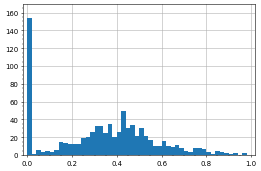

In [20]:
plt.hist(o['thresg'],bins=50,range=(0,1)); # GRU, tuned probability threshold (each per customer)

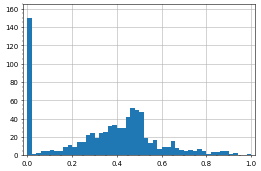

In [21]:
plt.hist(o['thresl'],bins=50,range=(0,1)); # LSTM, tuned probability threshold (each per customer)

F1 scores:

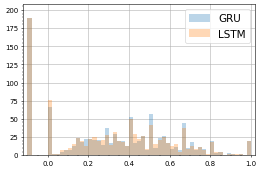

In [22]:
#f1 distribution
plt.hist(o['f1g'],bins=55,range=(-0.1,1),alpha=0.3,label='GRU')
plt.hist(o['f1l'],bins=55,range=(-0.1,1),alpha=0.3,label='LSTM')
plt.legend(fontsize=15);

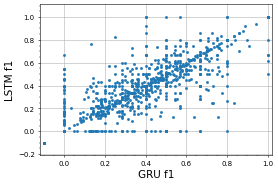

In [23]:
# scatter plot
plt.plot(o['f1g'],o['f1l'],'o',markersize=3);
plt.xlabel('GRU f1',fontsize=15);plt.ylabel('LSTM f1',fontsize=15);

x0= 0.01 ,sigma= 0.16


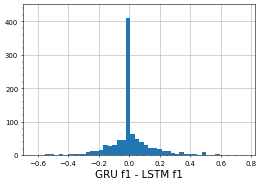

In [24]:
# histogram of difference
dgl = o['f1g'] - o['f1l'] 
plt.hist(dgl,bins=50)
plt.xlabel('GRU f1 - LSTM f1',fontsize=15)

from scipy.stats import norm
mu, sigma = norm.fit(dgl)
print('x0=',round(mu,2),',sigma=',round(sigma,2));

__2. GRU vs Baseline (copy last order)__

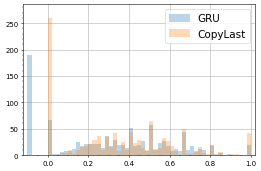

In [25]:
#f1 distribution
plt.hist(o['f1g'],bins=55,range=(-0.1,1),alpha=0.3,label='GRU')
plt.hist(o['f1b'],bins=55,range=(-0.1,1),alpha=0.3,label='CopyLast')
plt.legend(fontsize=15);

x0= -0.03 ,sigma= 0.31


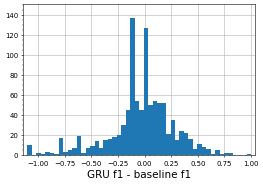

In [26]:
# difference GRU - baseline, hist
dgb = o['f1g'] - o['f1b']
plt.hist(dgb,bins=50)
plt.xlabel('GRU f1 - baseline f1',fontsize=15)

from scipy.stats import norm
mu, sigma = norm.fit(dgb)
print('x0=',round(mu,2),',sigma=',round(sigma,2));

What's the average f1 score if we ignore zeros?

In [27]:
# GRU:
mg = o['f1g']> 0
np.mean(o['f1g'][mg]).round(3)

0.448

In [28]:
# LSTM
ml = o['f1l']> 0
np.mean(o['f1l'][ml]).round(3)

0.443

In [29]:
# Baseline
mb = o['f1b']> 0
np.mean(o['f1b'][mb]).round(3)

0.47

The best result for this competition from the [Kaggle leaderboard](https://www.kaggle.com/c/instacart-market-basket-analysis/leaderboard) is 0.409. Understanding zeros is crucial.

__3. GRU prediction vs GRU test (prediction of the n-th vs (n-1)-th order)__

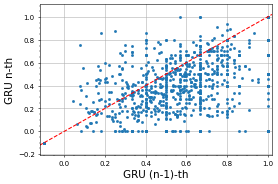

In [30]:
# scatter plot
plt.plot(o['f1gt'],o['f1g'],'o',markersize=3);
plt.xlabel('GRU (n-1)-th',fontsize=15);plt.ylabel('GRU n-th',fontsize=15)
plt.axline((0, 0), (1, 1),color='r', linestyle='--');

x0= -0.13 ,sigma= 0.24


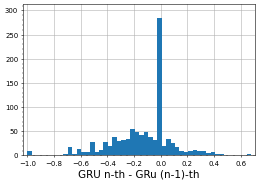

In [31]:
# histogram of difference
dgt = o['f1g'] - o['f1gt'] 
plt.hist(dgt,bins=50)
plt.xlabel('GRU n-th - GRu (n-1)-th',fontsize=15)

from scipy.stats import norm
mu, sigma = norm.fit(dgt)
print('x0=',round(mu,2),',sigma=',round(sigma,2));

GRU (n-1)-th better by 0.13 than GRU n-th. And generaly pretty wide sigma, which means there's a lot of randomness in the prediction. Same results, i.e. a peak at 0 is when too little data to train the model.

__4. Baseline prediction vs Baseline test (the n-th vs (n-1)-th order)__

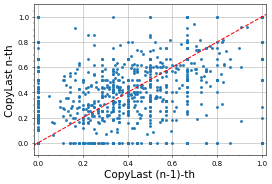

In [32]:
# scatter plot
plt.plot(o['f1bt'],o['f1b'],'o',markersize=3);
plt.xlabel('CopyLast (n-1)-th',fontsize=15);plt.ylabel('CopyLast n-th',fontsize=15)
plt.axline((0, 0), (1, 1),color='r', linestyle='--');

x0= 0.01 ,sigma= 0.3


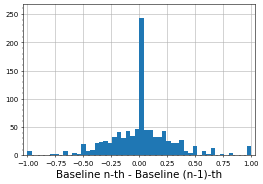

In [33]:
# histogram of difference
dbt = o['f1b'] - o['f1bt'] 
plt.hist(dbt,bins=50)
plt.xlabel('Baseline n-th - Baseline (n-1)-th',fontsize=15)

from scipy.stats import norm
mu, sigma = norm.fit(dbt)
print('x0=',round(mu,2),',sigma=',round(sigma,2));

__5. (GRU - Baseline) prediction vs (GRU - Baseline) test__

Can we decide which prediction is better, GRU or Baseline, looking at the GRU and Baseline from the previous step (test, n-1 prediction)?

In [34]:
gb = o['f1g'] - o['f1b']

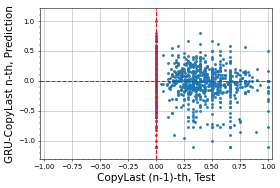

In [35]:
# vs CopyLast n-1
plt.plot(o['f1bt'],gb,'o',markersize=3);
plt.xlabel('CopyLast (n-1)-th, Test',fontsize=15);plt.ylabel('GRU-CopyLast n-th, Prediction',fontsize=15)
plt.axline((0, -1), (0, 1),color='r', linestyle='--')
plt.axline((-1, 0), (1, 0),color='r', linestyle='--');

Nope, CopyLast at n-1 not helpful.

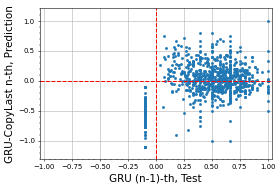

In [36]:
# vs GRU n-1
plt.plot(o['f1gt'],gb,'o',markersize=3);
plt.xlabel('GRU (n-1)-th, Test',fontsize=15);plt.ylabel('GRU-CopyLast n-th, Prediction',fontsize=15)
plt.axline((0, -1), (0, 1),color='r', linestyle='--')
plt.axline((-1, 0), (1, 0),color='r', linestyle='--');

If GRU n-1 not existing (hard coded -0.1) then GRU n doesn't exist either. We would use the Baseline anyway. Other than that, no clear correlation... sadly.

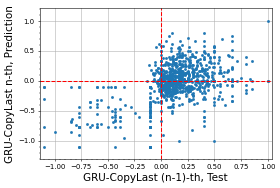

In [37]:
gbt = o['f1gt'] - o['f1bt']

# scatter plot
plt.plot(gbt,gb,'o',markersize=3);
plt.xlabel('GRU-CopyLast (n-1)-th, Test',fontsize=15);plt.ylabel('GRU-CopyLast n-th, Prediction',fontsize=15)
plt.axline((0, -1), (0, 1),color='r', linestyle='--')
plt.axline((-1, 0), (1, 0),color='r', linestyle='--');

Same here, difference n-th vs difference (n-1)-th doesn't show any insight. This fact again tells us the randomness in the data.

__6. (GRU - Baseline) prediction vs other features__

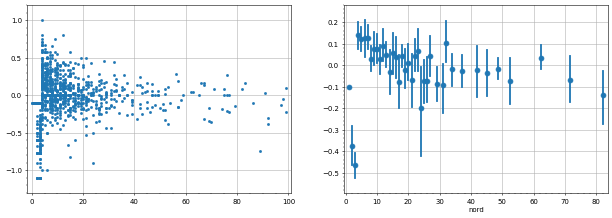

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(o['nord'],gb,'o',markersize=3)
sns.regplot(x=o['nord'], y=gb, x_bins=100,fit_reg=None,ax=ax[1]);

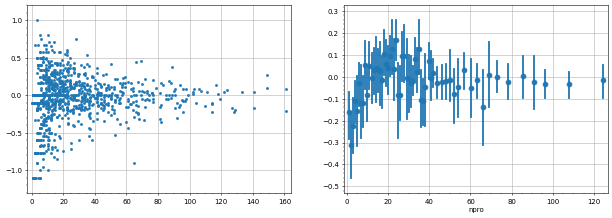

In [39]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(o['npro'],gb,'o',markersize=3)
sns.regplot(x=o['npro'], y=gb, x_bins=100,fit_reg=None,ax=ax[1]);

On average, GRU better than Baseline for low number of orders (<15) and about 20 products. Why? Is it again due to randomness? Should we use only last 15 orders for modeling?

Any correlation between GRU - CopyLast n-th and other features in the original dataset?

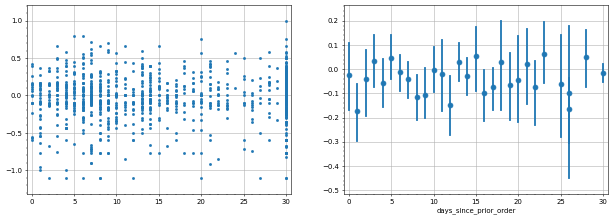

In [40]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(o['days_since_prior_order'],gb,'o',markersize=3)
sns.regplot(x=o['days_since_prior_order'], y=gb, x_bins=100,fit_reg=None,ax=ax[1]);

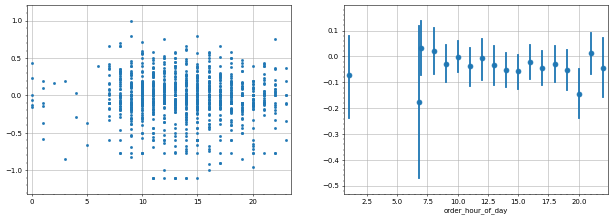

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(o['order_hour_of_day'],gb,'o',markersize=3);
sns.regplot(x=o['order_hour_of_day'], y=gb, x_bins=100,fit_reg=None,ax=ax[1]);

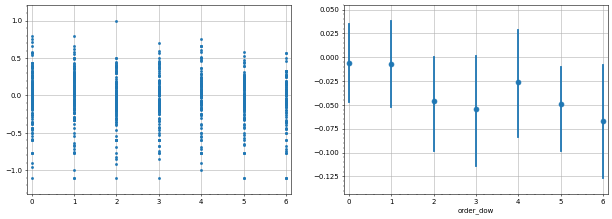

In [42]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(o['order_dow'],gb,'o',markersize=3);
sns.regplot(x=o['order_dow'], y=gb, x_bins=100,fit_reg=None,ax=ax[1]);

Nope.